In [1]:
import pandas as pd
import numpy as np


# statistics 
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# visualisation 
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [4]:
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization

## Goal is to determine a pet photo’s appeal to give rescue animals a higher chance of being adopted

## This dataset is taken from the kaggle competition https://www.kaggle.com/competitions/petfinder-pawpularity-score/data 

When the key features of the most frequently adopted animals are defined, they can be helphul for improving photos of animals in all shelters to increase their chances of finding their loving homes 

Our input and outputs are: 
* Input: photo of an animal and photo metadata
* Output: an estimate the 'pawpularity' score of the pet.

Files: in {id}.img format (id is the unique name of the pet) and train.csv has photo metadata and scores. 

Photo metadata:
* Focus - Pet stands out against uncluttered background, not too close / far.
* Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.
* Face - Decently clear face, facing front or near-front.
* Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).
* Action - Pet in the middle of an action (e.g., jumping).
* Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.
* Group - More than 1 pet in the photo.
* Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).
* Human - Human in the photo.
* Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.
* Info - Custom-added text or labels (i.e. pet name, description).
* Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0.

Grading metric: RMSE between the predicted value and the observed target.

# Let's have a look at the data 

In [2]:
!ls petfinder-pawpularity-score

sample_submission.csv  test  test.csv  train  train.csv


In [10]:
!ls petfinder-pawpularity-score/train | head -n 5

0007de18844b0dbbb5e1f607da0606e0.jpg
0009c66b9439883ba2750fb825e1d7db.jpg
0013fd999caf9a3efe1352ca1b0d937e.jpg
0018df346ac9c1d8413cfcc888ca8246.jpg
001dc955e10590d3ca4673f034feeef2.jpg
ls: write error: Broken pipe


In [5]:
train_df = pd.read_csv('petfinder-pawpularity-score/train.csv')
train_df[0:2]

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42


In [6]:
test_df = pd.read_csv('petfinder-pawpularity-score/test.csv')
test_df[0:2]

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0


Since test dataset does not have our target variable, we will split train set into actual train, validation and test 

# EDA: metadata features 

In [7]:
train_df.shape[0] #9912 photos 

9912

In [8]:
train_df.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


### Some observations: 

* total number of observations are 9912 
* Pawpularity's range is 1 to 100 and Pawpularity's mean is only 38.03% (it's quite sad, isn't? I would give them all 100%) 
* metadata features have only 0 and 1 values
* Action, Subject Focus and Collage	features have the lowest means meaning the the most photos are taken not in the middle of action, the background is a not perfectly clear and it is not digitally-retouched photo. Blur and Info features also have low mean values (images are not blurred and not much extra info is provided on the photo)
* Near, Face and Eyes features have the the highest means suggesting that most photos have only one pet per photo with decently clear front-facing face and eyes

### Let's have a look at the distribution of a score based on features: 

In [9]:
long_train_df = pd.melt(train_df, id_vars='Id', value_vars=['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']).merge(train_df[['Id', 'Pawpularity']], 
                                                                       on='Id', how='inner')

long_train_df[0:4]

,Id,variable,value,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,Subject Focus,0,63
1,0007de18844b0dbbb5e1f607da0606e0,Eyes,1,63
2,0007de18844b0dbbb5e1f607da0606e0,Face,1,63
3,0007de18844b0dbbb5e1f607da0606e0,Near,1,63


### We will calculate the statistical tests to compare differences in scores for different features

In [10]:
pvalues = []
for variable in long_train_df['variable'].unique():
    one = long_train_df[(long_train_df['variable'] == variable) & (long_train_df['value'] == 0)]['Pawpularity'].tolist()
    two = long_train_df[(long_train_df['variable'] == variable) & (long_train_df['value'] == 1)]['Pawpularity'].tolist()
    pval = mannwhitneyu(one, two, alternative="two-sided").pvalue
    pvalues.append(pval)
   

# multiple testing correction
pvalues_lables = list(map(lambda n: str(np.round(n,2)) if n<=0.05 else 'ns', list(multipletests(pvalues, method = 'fdr_bh')[1])))

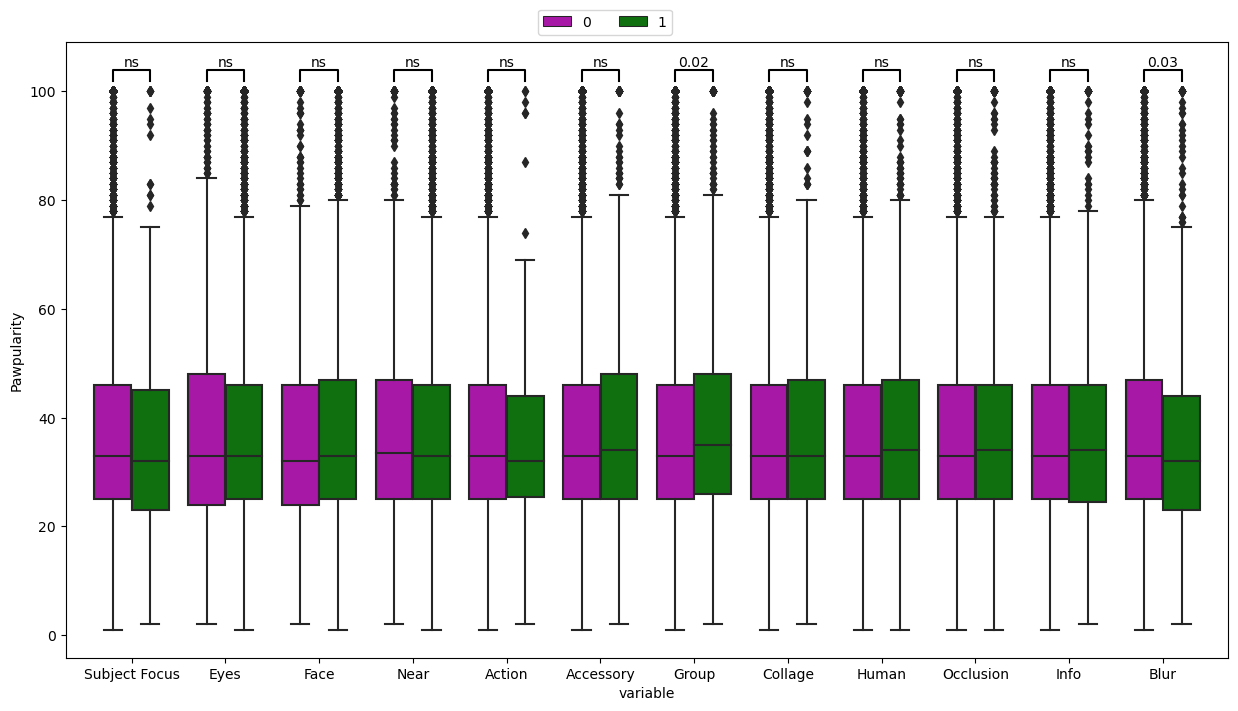

In [11]:
plt.figure(figsize=(15,8))

li = [[-0.2, 0.2], [0.8, 1.2], [1.8, 2.2], [2.8, 3.2], 
      [3.8, 4.2], [4.8, 5.2], [5.8, 6.2], [6.8, 7.2], 
      [7.8, 8.2], [8.8, 9.2], [9.8, 10.2], [10.8, 11.2], 
     [11.8, 12.2]]

sns.boxplot(x="variable", y="Pawpularity",
            hue="value", palette=["m", "g"],
            data=long_train_df)

# statistical annotation
for x,pv in zip(li,pvalues_lables):
    x1, x2 = x 
    y, h, col = long_train_df['Pawpularity'].max() + 2, 2, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, pv, ha='center', va='bottom', color=col)
    

plt.legend(bbox_to_anchor =(0.4, 1), ncol = 2)

#### Couple observations: 
* mostly there are no significant differences in scores for different features after multiple testing correction
* only Group and Blur features showed significant differences (adj pvalue < 0.05). The more animals on the photo the higher is the score and 
the less blurry picture - the higher is the score. 

However, taken together, we can start with using only images for our models since the metadata features do not like they contain a lot of information, except, maybe, Group and Blur features

# EDA: images 

### Let's display a subsample of images

In [12]:
long_train_df['path'] = 'petfinder-pawpularity-score/train/'+long_train_df['Id']+'.jpg'
images_filepaths = long_train_df['path'].tolist()

In [19]:
images_filepaths_subset = long_train_df.sample(n=20)['path'].tolist()

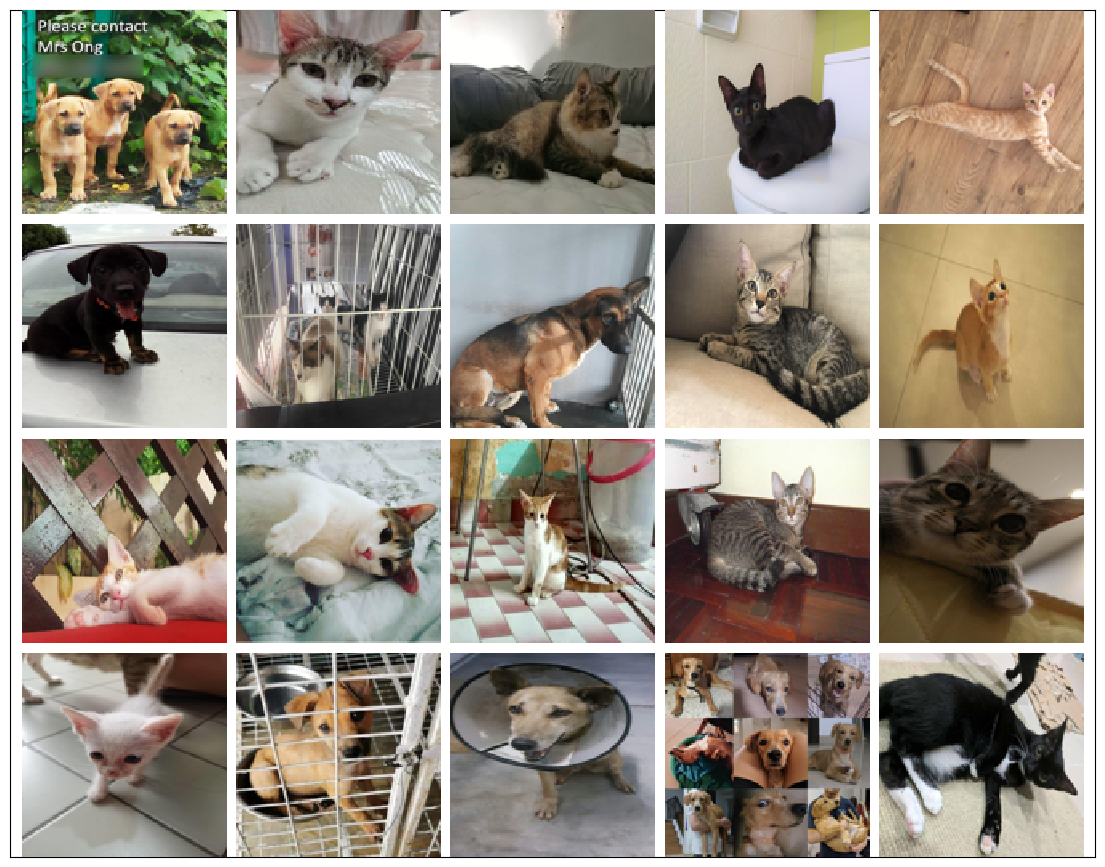

In [21]:
fig, ax = plt.subplots(figsize=(14, 11))


plt.rcParams["axes.grid"] = False


grid = ImageGrid(fig, 111,
                 nrows_ncols=(4,5),
                 axes_pad=0.1,
                 share_all=True,
                 label_mode = '1'
                 )


for i, image_filepath in enumerate(images_filepaths_subset):

    score_label = long_train_df[long_train_df['Id'] == image_filepath.split('/')[-1].split('.')[0]]
    img = Image.open(image_filepath)
    img = img.resize((128, 128))
    grid[i].imshow(img,cmap='gray',interpolation='none')
    grid[i].axis("off")
    
    grid[i].get_yaxis().set_ticks([])
    grid[i].get_xaxis().set_ticks([])

ax.set_xticks([])
ax.set_yticks([])

plt.show()

Clearly we can see that sometimes photos are collages or have unusual shapes and verying sizes and rotations. We may benefit from augmentations 

### Look at image sizes: 

### Let's split scores into 3 categoris: below 25% percentile, between 25% and 75% and above 75% and check the distribution of values 

In [22]:
perc25 = np.percentile(long_train_df['Pawpularity'], 25)
perc50 = np.percentile(long_train_df['Pawpularity'], 50)
perc75 = np.percentile(long_train_df['Pawpularity'], 75)

In [23]:
def map_Pawpularity(x):
    
    if x['Pawpularity'] <= perc25: 
        return '<perc25'
    elif (x['Pawpularity'] > perc25) & (x['Pawpularity'] < perc75):
        return '[perc25, perc75]'
    else:
        return '>=perc75'

In [24]:
long_train_df['map_Pawpularity'] = long_train_df.apply(map_Pawpularity, axis=1)

In [25]:
long_train_df.groupby(by='map_Pawpularity')['value'].count().to_dict()

{'<perc25': 31656, '>=perc75': 31152, '[perc25, perc75]': 56136}

Distribution is skewed to the right (higher scores; there was probably not much sense doing that - instead we can look at distribution in a form of histogram; this was 'attempt' to show some imbalance in target values distribution)

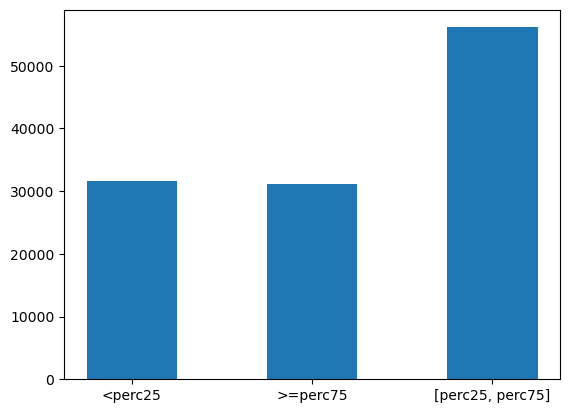

In [26]:
plt.bar(long_train_df.groupby(by='map_Pawpularity')['value'].count().to_dict().keys(), 
        long_train_df.groupby(by='map_Pawpularity')['value'].count().to_dict().values(), width = .5);

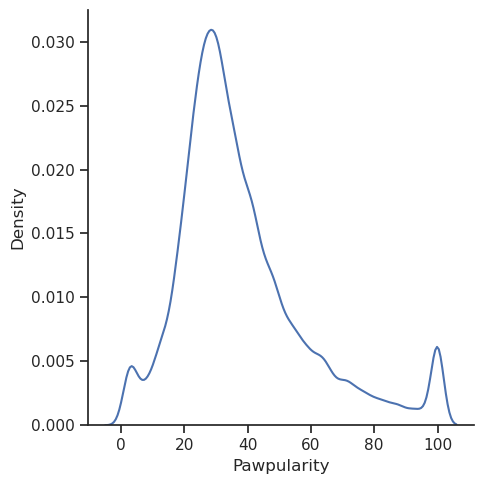

In [135]:
sns.displot(x = 'Pawpularity', data=long_train_df, kind='kde')

# Would we benefit from log transformation of the target variable? 

this can lead to a distribution closer to normal - it may benefit the linear regression 

# Now we can split the dataset intro test/train/val

In [27]:
train_df['filename'] = train_df['Id']+'.jpg'

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(train_df['filename'].tolist(),
                                                    train_df['Pawpularity'].tolist(),
                                                    test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                    y_train_val,
                                                    test_size=0.2, random_state=42)

In [29]:
len(X_train), len(X_val), len(X_test)

(6343, 1586, 1983)

In [30]:
train_selected_df = train_df[train_df['filename'].isin(X_train)][['filename', 'Pawpularity']]

test_selected_df = train_df[train_df['filename'].isin(X_test)][['filename', 'Pawpularity']]

val_selected_df = train_df[train_df['filename'].isin(X_val)][['filename', 'Pawpularity']]

# Use keras data generators: we will start with simple normalisation and resize images to (150,150)

In [31]:
image_dir = 'petfinder-pawpularity-score/train/'

In [32]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_selected_df, 
    directory=image_dir, 
    x_col="filename", 
    y_col="Pawpularity", 
    has_ext=True, 
    class_mode="other", 
    target_size=(150, 150), 
    batch_size=20
)

Found 6343 validated image filenames.


In [33]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_selected_df, 
    directory=image_dir, 
    x_col="filename", 
    y_col="Pawpularity", 
    has_ext=True, 
    class_mode="other", 
    target_size=(150, 150), 
    batch_size=20
)

Found 1983 validated image filenames.


In [34]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_selected_df, 
    directory=image_dir, 
    x_col="filename", 
    y_col="Pawpularity", 
    has_ext=True, 
    class_mode="other", 
    target_size=(150, 150), 
    batch_size=20
)

Found 1586 validated image filenames.


# Model 0: linerar regression for regression problem :) 

NN that has only nodes with linear activation function, it will result in linear regression method 

In [78]:
model = models.Sequential()
 
# Define the model consisting of a single neuron.
model.add(layers.Dense(units=1, input_shape=(150, 150, 3), activation = "linear"))
model.add(layers.Flatten())
model.add(layers.Dense(units=1, activation = "linear"))
 
# Display a summary of the model architecture.
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 150, 150, 1)       4         
                                                                 
 flatten (Flatten)           (None, 22500)             0         
                                                                 
 dense_11 (Dense)            (None, 1)                 22501     
                                                                 
Total params: 22,505
Trainable params: 22,505
Non-trainable params: 0
_________________________________________________________________


In [86]:
# compile the model. Notice that loss is MSE (mean squared error)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=.005),
              loss='mse', metrics=["mean_absolute_error"])

In [87]:
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=val_generator,
                    batch_size=16)

Epoch 1/10


2023-12-31 10:51:12.371933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


318/318 [==============================] - 94s 297ms/step - loss: 651.5273 - mean_absolute_error: 19.4344 - val_loss: 708.8269 - val_mean_absolute_error: 21.5025
Epoch 2/10
318/318 [==============================] - 100s 315ms/step - loss: 607.6795 - mean_absolute_error: 18.6500 - val_loss: 1196.2582 - val_mean_absolute_error: 29.5747
Epoch 3/10
318/318 [==============================] - 93s 293ms/step - loss: 592.4551 - mean_absolute_error: 18.4298 - val_loss: 535.8710 - val_mean_absolute_error: 16.8734
Epoch 4/10
318/318 [==============================] - 99s 312ms/step - loss: 567.2178 - mean_absolute_error: 18.0703 - val_loss: 636.2475 - val_mean_absolute_error: 17.5961
Epoch 5/10
318/318 [==============================] - 98s 309ms/step - loss: 551.9972 - mean_absolute_error: 17.7323 - val_loss: 512.9083 - val_mean_absolute_error: 16.8567
Epoch 6/10
318/318 [==============================] - 98s 310ms/step - loss: 539.7531 - mean_absolute_error: 17.5963 - val_loss: 557.0176 - val_

<Figure size 640x480 with 0 Axes>

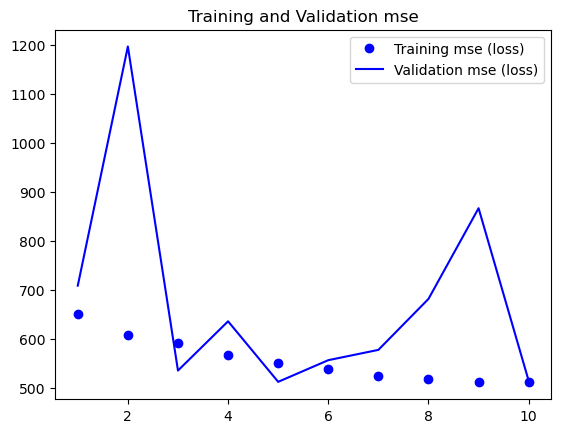

<Figure size 640x480 with 0 Axes>

In [88]:
mse = history.history['loss']
val_mse = history.history['val_loss']

epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'bo', label='Training mse (loss)')
plt.plot(epochs, val_mse, 'b', label='Validation mse (loss)')
plt.title('Training and Validation mse')
plt.legend()

plt.figure()

In [89]:
pred = model.predict(test_generator)

  1/100 [..............................] - ETA: 14s

2023-12-31 11:12:31.238020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 19s 190ms/step


In [83]:
pred.shape

(1983, 1)

Text(0.5, 0, 'true values')

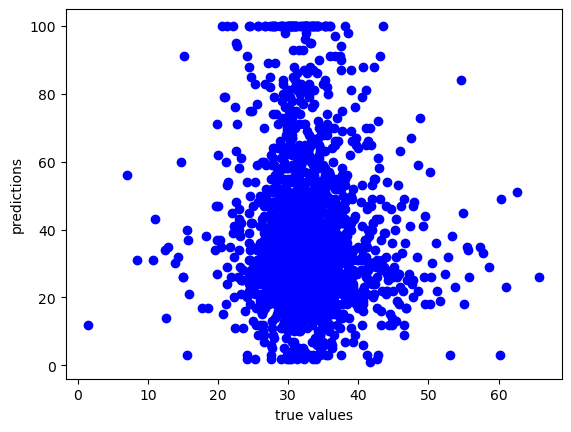

In [91]:
plt.scatter(x=pred, 
            y=test_selected_df['Pawpularity'].tolist(), c ="blue")

plt.ylabel('predictions')
plt.xlabel('true values')

In [ ]:
model.evaluate(test_ds)

In [ ]:
residuals = test_selected_df['Pawpularity'].tolist() - pred
sns.distplot(residuals)

# Let's define the basic model, Model 1. It will use only images:

notice that since it's a regression model, we need to define the correct loss: 'mean_squared_error', also the final Dense layer should have activation 'linear'

In [92]:
model = models.Sequential()

model.add(layers.Dense(32, input_shape=(150, 150, 3)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation = "linear"))

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=.005),
              loss='mse', metrics=["mean_absolute_error"])

In [93]:
history = model.fit(train_generator, epochs=20, 
                    validation_data=val_generator,
                    batch_size=64)

Epoch 1/20


2023-12-31 11:15:07.035687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


318/318 [==============================] - ETA: 0s - loss: 5679.3926 - mean_absolute_error: 26.8525

2023-12-31 11:16:51.842180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


318/318 [==============================] - 127s 399ms/step - loss: 5679.3926 - mean_absolute_error: 26.8525 - val_loss: 493.4058 - val_mean_absolute_error: 16.4251
Epoch 2/20
227/318 [====================>.........] - ETA: 37s - loss: 644.3613 - mean_absolute_error: 19.3661

KeyboardInterrupt: 

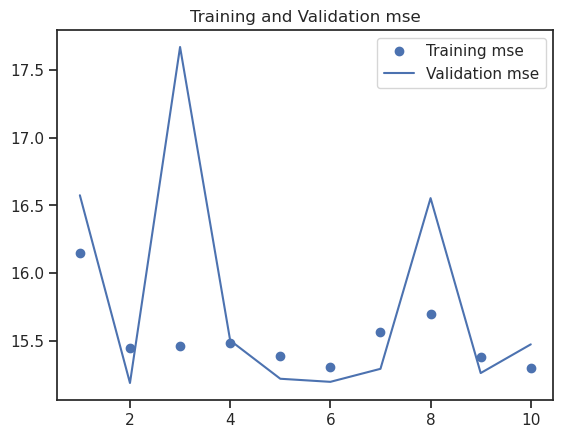

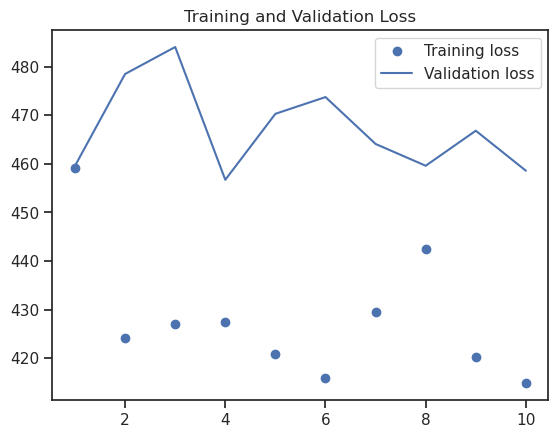

In [317]:
mse = history.history['mse']
val_mse = history.history['val_mse']

epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and Validation mse')
plt.legend()

plt.show()

In [335]:
pred = model.predict(test_generator)


  1/100 [..............................] - ETA: 13s

2023-12-27 00:04:38.573538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 10s 101ms/step


In [339]:
pred.shape

(44617500, 1983)

ValueError: x and y must be the same size

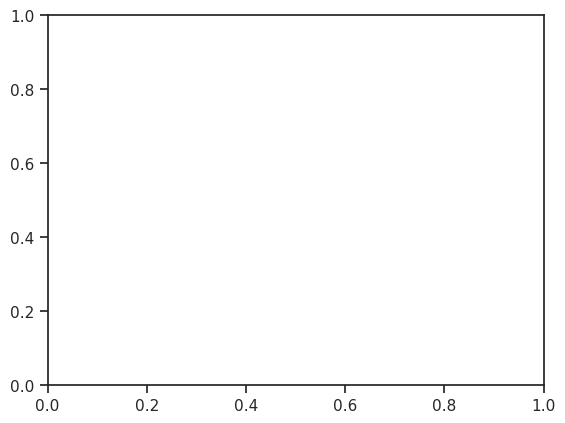

In [333]:
plt.scatter(x=pred, 
            y=test_selected_df['Pawpularity'].tolist(), c ="blue")

plt.ylabel('predictions')
plt.xlabel('true values')

In [ ]:
model.evaluate(test_ds)

In [ ]:
residuals = test_selected_df['Pawpularity'].tolist() - pred
sns.distplot(residuals)

In [ ]:
# rmse
r2_score(y_test, preds)  

# Let's try another architecture with more layers: Model2 

In [ ]:
model = models.Sequential()

model.add(Dense(32, input_shape=(150, 150, 3)))
model.add(Dense(64,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(1,activation = "linear"))

model.compile(loss='mean_squared_error',
             optimizer=keras.optimizers.Adam(learning_rate=0.1),
             metrics=["mean_absolute_error"])

In [ ]:
history = model.fit(train_generator, epochs=10, 
                    validation_data=val_generator,
                    batch_size=64)

In [ ]:
mse = history.history['mean_absolute_error']
val_mse = history.history['val_mean_absolute_error']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and Validation mse')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
pred = model.predict(test_generator)

In [ ]:
plt.scatter(x=test_selected_df['Pawpularity'], y=pred, c ="blue")

# Model3: Convolutional Neural Network for regression

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape = (150, 150, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(1, activation = "linear"))

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=.005),
              loss='mse', metrics=["mean_absolute_error"])

model.summary()

In [ ]:
history = model.fit(train_generator, epochs=10, 
                    validation_data=val_generator,
                    batch_size=64)

In [ ]:
mse = history.history['mse']
val_mse = history.history['val_mse']


epochs = range(1, len(mse) + 1)

plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and Validation mse')
plt.legend()

plt.figure()

In [ ]:
pred = model.predict(test_generator)

In [ ]:
plt.scatter(x=test_selected_df['Pawpularity'], y=pred, c ="blue")

# Let's tune params for Model 2: dropout and learning rate

# Let's use a pretrained model and add layers 

# Non-NN models 